## Markowitz portfolio optimization

 In this notebook we optimize a portfolio of BTC, ETH, LTC and XRP. We extract the  BTC/USDT, ETH/USDT, LTC/USDT and XRP/USDT data from Poloneix. Since coins/USDT pairs are almost same as coins/USD pairs,it works for us. Later, perform monte carlo simulation to find the best Sharpe ratio for our portfolio. Finally, we apply Markowitz Portfolio Optimization.  


In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df


In [3]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2016-01-01', '%Y-%m-%d') 
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [39]:
crypto = ['ETH','LTC','XRP','ETC','BTC','BCH']

crypto_data = {}
for coin in crypto:
    coinpair = 'USDT_{}'.format(coin)
    crypto_price_df = get_crypto_data(coinpair)
    crypto_data[coin] = crypto_price_df


Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1451635200.0&end=1629332617.68241&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_LTC&start=1451635200.0&end=1629332617.68241&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_XRP&start=1451635200.0&end=1629332617.68241&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETC&start=1451635200.0&end=1629332617.68241&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1451635200.0&end=1629332617.68241&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BCH&start=1451635200.0&end=1629332617.68241&period=86400 from cache


In [5]:
crypto_data['BTC'].head()

,high,low,open,close,volume,quoteVolume,weightedAverage
date,,,,,,,
2016-01-01 08:00:00,434.990000,434.990000,434.990000,434.990000,0.000000,0.000000,434.990000
2016-01-02 00:00:00,438.140000,430.500000,434.990000,436.949900,944.853289,2.179981,433.422678
2016-01-03 00:00:00,435.614998,426.453089,432.310000,428.140000,683.918470,1.596349,428.426673
2016-01-04 00:00:00,435.999999,427.291140,427.291141,432.000011,724.976004,1.673428,433.228179
2016-01-05 00:00:00,435.999999,429.569500,430.140211,430.376774,427.647283,0.992530,430.865842


In [6]:
dfp = pd.concat([crypto_data['BTC']['close'],crypto_data['ETH']['close'],crypto_data['LTC']['close'],crypto_data['XRP']['close']], axis=1)

In [7]:
dfp.head()

,close,close,close,close
date,,,,
2016-01-01 08:00:00,434.990000,0.959136,3.563049,0.005999
2016-01-02 00:00:00,436.949900,0.957000,3.569990,0.006127
2016-01-03 00:00:00,428.140000,0.960499,3.435230,0.006149
2016-01-04 00:00:00,432.000011,0.962224,3.435230,0.006149
2016-01-05 00:00:00,430.376774,0.939382,3.435234,0.006149


In [8]:
dfp.columns = ['BTC','ETH', 'LTC','XRP']

In [9]:
dfp.tail()

,BTC,ETH,LTC,XRP
date,,,,
2021-08-15,46988.892027,3308.397345,184.684700,1.286865
2021-08-16,45931.962671,3147.663378,178.224920,1.192284
2021-08-17,44690.863383,3011.825692,168.765678,1.098555
2021-08-18,44725.927276,3011.953656,166.592837,1.143254
2021-08-19,44696.137935,3017.479385,166.294400,1.141716


In [10]:
dfp = dfp.loc['2017-01-01':] # Keeping the data from 2017

In [11]:
mean_daily_ret = dfp.pct_change(1).mean()
mean_daily_ret

BTC    0.003198
ETH    0.005183
LTC    0.004165
XRP    0.006401
dtype: float64

In [12]:
dfp.pct_change(1).corr()  # Correlation matrix

,BTC,ETH,LTC,XRP
BTC,1.000000,0.672057,0.648770,0.374546
ETH,0.672057,1.000000,0.647185,0.400752
LTC,0.648770,0.647185,1.000000,0.444474
XRP,0.374546,0.400752,0.444474,1.000000


<AxesSubplot:xlabel='date'>

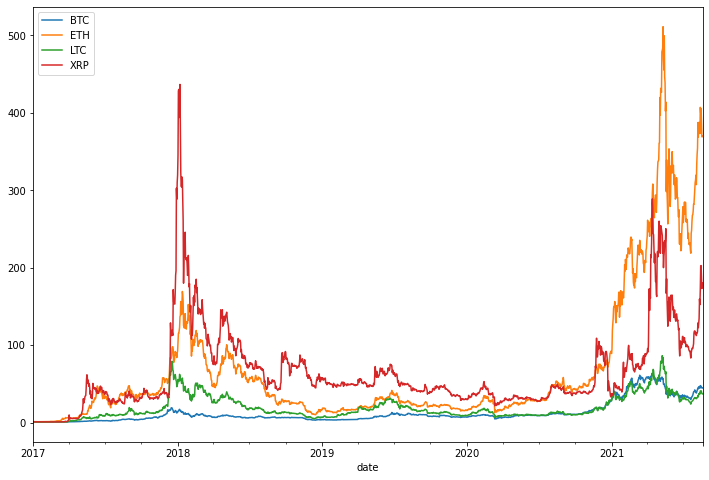

In [13]:
crypto_normed = dfp/dfp.iloc[0]
crypto_normed['2017-01-01':].plot(figsize=(12,8))

In [14]:
dfp.head()

,BTC,ETH,LTC,XRP
date,,,,
2017-01-01,999.364640,8.161638,4.486000,0.006346
2017-01-02,1019.000001,8.389086,4.605872,0.006316
2017-01-03,1037.100000,9.653000,4.590000,0.006411
2017-01-04,1136.000000,11.100000,4.603085,0.006613
2017-01-05,998.800000,10.090000,4.241776,0.006300


In [15]:
crypto_daily_ret = dfp.pct_change(1)  # Daily return
crypto_daily_ret.head()

,BTC,ETH,LTC,XRP
date,,,,
2017-01-01,NaN,NaN,NaN,NaN
2017-01-02,0.019648,0.027868,0.026721,-0.004636
2017-01-03,0.017763,0.150662,-0.003446,0.014982
2017-01-04,0.095362,0.149902,0.002851,0.031588
2017-01-05,-0.120775,-0.090991,-0.078493,-0.047392


In [16]:
log_ret = np.log(dfp/dfp.shift(1))  #Log return
log_ret.head()

,BTC,ETH,LTC,XRP
date,,,,
2017-01-01,NaN,NaN,NaN,NaN
2017-01-02,0.019457,0.027487,0.026370,-0.004647
2017-01-03,0.017607,0.140337,-0.003452,0.014871
2017-01-04,0.091085,0.139676,0.002847,0.031100
2017-01-05,-0.128714,-0.095400,-0.081745,-0.048551


C:\Users\Rocky\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


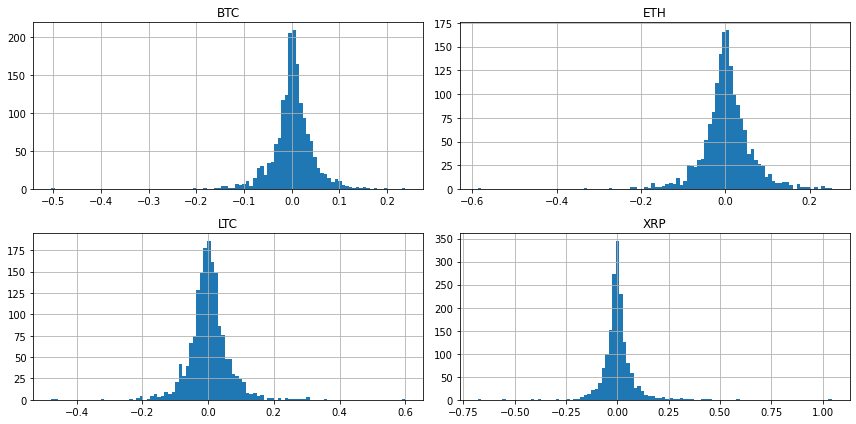

In [17]:
log_ret.hist(bins=100,figsize=(12,6));
plt.tight_layout()

In [18]:
log_ret.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BTC,1691.0,0.002248,0.043762,-0.504355,-0.016209,0.002409,0.022310,0.238142
ETH,1691.0,0.003497,0.058138,-0.586968,-0.022500,0.002176,0.030746,0.252744
LTC,1691.0,0.002136,0.063159,-0.477961,-0.028438,-0.000140,0.028529,0.600512
XRP,1691.0,0.003071,0.078870,-0.680387,-0.026073,-0.000515,0.024719,1.046054


In [19]:
log_ret.mean() * 252

BTC    0.566370
ETH    0.881140
LTC    0.538395
XRP    0.773810
dtype: float64

In [20]:
log_ret.cov()

,BTC,ETH,LTC,XRP
BTC,0.001915,0.001776,0.001904,0.001524
ETH,0.001776,0.003380,0.002538,0.002212
LTC,0.001904,0.002538,0.003989,0.002576
XRP,0.001524,0.002212,0.002576,0.006220


In [21]:
num_ports = 10000

all_weights = np.zeros((num_ports,len(dfp.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(4))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [22]:
sharpe_arr.max()

0.985171803468677

In [23]:
sharpe_arr.argmax()

1185

In [24]:
all_weights[sharpe_arr.argmax(),:]

array([0.20642562, 0.64122908, 0.00154206, 0.15080324])

In [25]:
dfp.columns

Index(['BTC', 'ETH', 'LTC', 'XRP'], dtype='object')

In [26]:
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]
print('Return with Maximum SR')
print(max_sr_ret)
print('Volality with Maximum SR')
print(max_sr_vol)

Return with Maximum SR
0.7994494878305081
Volality with Maximum SR
0.8114823069597993


## So according to the analysis 70% of our portfolio should be allocated to Etherum ! 

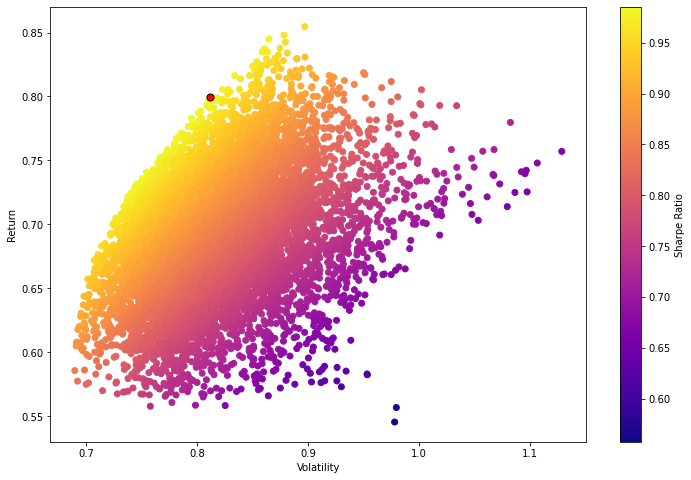

In [27]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

In [28]:
## Efficient Frontier
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(.9,1.8,50) # Change 100 to a lower number for slower computers!

In [29]:
# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

In [30]:
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

In [31]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [32]:
# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

In [33]:
# Initial Guess (equal distribution)
init_guess = [0.25,0.25,0.25,0.25]

In [34]:
from scipy.optimize import minimize

In [35]:
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

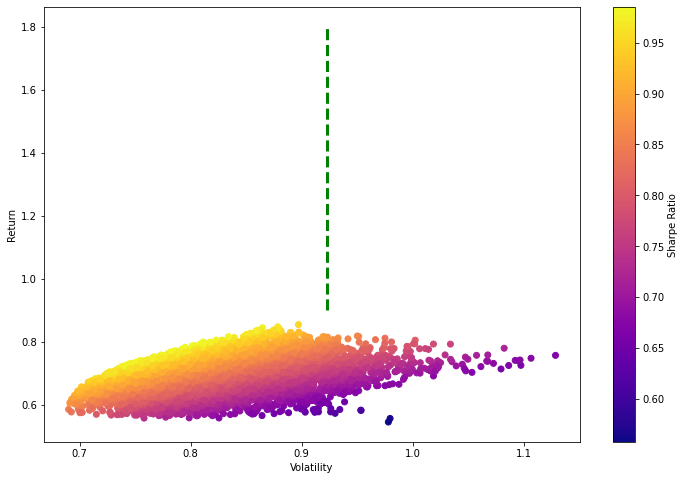

In [36]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')



# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)